# OSCAR - The Ostensibly Smart Computer Aided Recycler

## DSIR 1019 Capstone Project by Billy Horn
## Problem Statement
---
Recycling contamination occurs when items end up in a single-streamed recycling bin that cannot be processed by its destined facility. Aside from the typical garbage contaminants, other examples of recycling contamination include plastic bags, plastic film, electronics and plastic utensils, to name a few.

Recycling contaminants can vary depending on region due to different municipality accommodations and product availability. In the city of San Diego, CA, it is estimated that 15 - 17% of collected recyclables are contaminants, which equates to 10,000 tons of trash annually (source). The recycling facilities separate the items they cannot process and send them to the landfill, even if they could be recycled by a different facility. The strain on the recycling industry is real, threatening its viability due to increased processing costs and lower return on the recycled product.(source).

The Ostensibly Smart Computer Aided Recycler (OSCAR) project is offered as an aid to mitigate recycling contamination, aiming to cutoff improper sorting at the consumer. With the aid of a convolutional neural network trained on images of garbage, OSCAR will attempt to classify images into six categories:
glass, metal, cardboard, paper, plastic, trash
With a crowd-soured data set planned via the `website` portion of this repo, the OSCAR project hopes to amass enough categorized images to predict if an item can be recycled or not (stretch goal).

OSCAR can been deployed to portable iOS devices using the demo application found in the `app` section of this repo.

## Acknowledgements
The image classification tutorial provided by TensorFlow was used to complete this project. Code snippets from this project may be similar or identical to code from the tutorial. See links below:

https://www.tensorflow.org/tutorials/images/classification

https://www.tensorflow.org/tutorials/load_data/images

In [175]:
# Import libraries and modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import PIL
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils

# For reproducibility
np.random.seed(1909)

## Data Processing

In [6]:
# Setting path where data set resides
data_dir = '../data/training-testing/'
data_dir = Path(data_dir)

Let's have a look at the class labels.

In [7]:
classes = os.listdir(data_dir)
classes

['paper', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

### Train/Test Split

Keras makes it easy to import the data and perform the train/test split simultaneously. First, we need to set some parameters for the images, such as `img_height` and `img_width` to ensure all images are imported as the same size.

In [206]:
# Parameters to pass when importing and preprocessing images
batch_size = 32
img_height = 384
img_width = 512
train_size = 0.8
test_size = 1 - train_size

In [207]:
# Defining training data set
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=test_size,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=1909
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [208]:
# Defining training data set
ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=test_size,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=1909
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


We need to redifine our `classes` variable to maintain the order contained within the data set.

In [209]:
classes = ds_train.class_names
num_classes = len(classes)

classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Exploring the Data

Now we can take a look at our data. It appears most are photographs of garbage taken with a white backdrop. They are taken from different angles, which could make for a good data set due to the model being able to learn the features of the images from different perspectives. That way, the model has a wider tolerance when predicting on testing data.

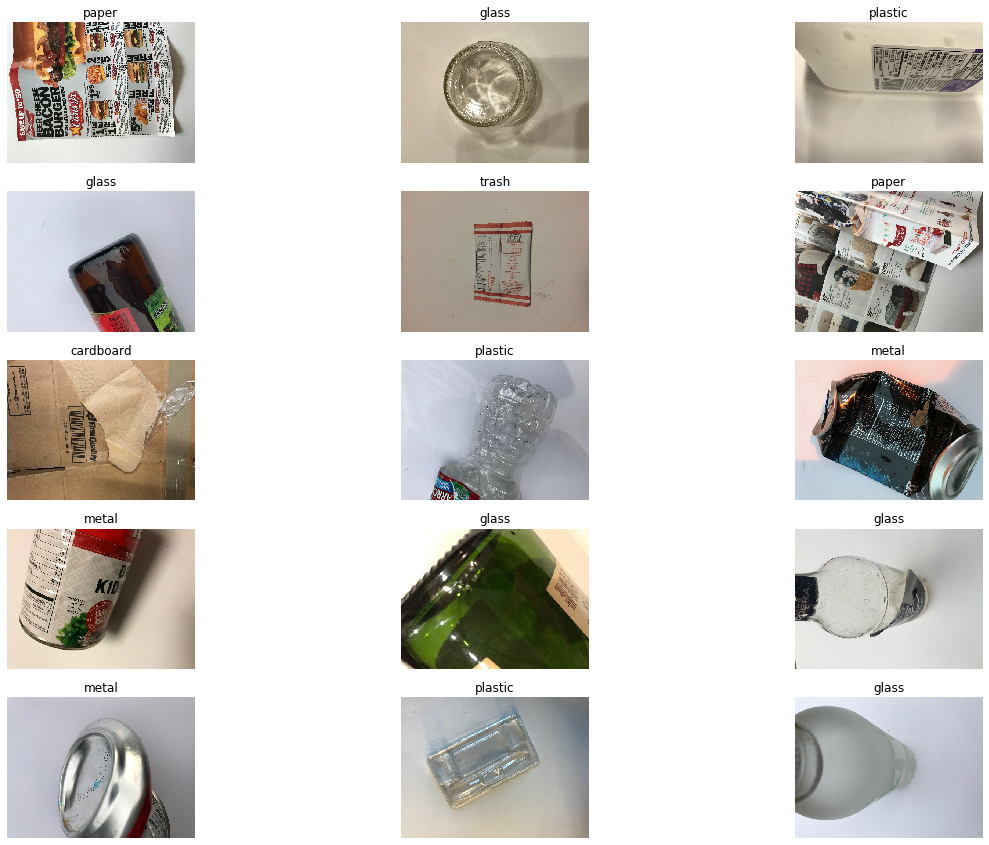

In [156]:
# Provide total images desired in multiples of 3
total_images = 15

# Display subset of images
plt.figure(figsize=(20, 15))
for images, labels in ds_train.take(1):
  for i in range(total_images):
    ax = plt.subplot(total_images // 3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")
    plt.tight_layout

In the plot above, we can confirm our `classes` variable has the correct order because they correspond with the approprate images. Fortunately, it appears there is no more cleaning needed for the photographs.

Before moving forward, it's good practice to ensure the image batch shape is the same legnth of the labels batch array. 

In [26]:
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 384, 512, 3)
(32,)


### Modifying Data for Better Performance

The below code is suggested by TensorFlow to help with computer performance when training data sets of images by keeping the images in memory for all epochs.

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [28]:
ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

The data should be normalized for processing by the model so all values in the image matrix will be between 0 and 1. All values will be divided by 255 because that is the highest channel value for color images.

In [160]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1 / 255)

In [161]:
normalized_ds = ds_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Sanity check to see if values are between 0 and 1
np.min(first_image), np.max(first_image)

0.002267157 1.0


## Modeling

### Baseline Scores

We need a frame of reference for how our model is performing. In this case, our baseline scores are just the ratios of how many images are in a category to the total number of images in the data set.

In [8]:
# Finding total number of files in each directory
trash = sum([1 for file in os.listdir('../data/training-testing/trash')])
metal = sum([1 for file in os.listdir('../data/training-testing/metal')])
glass = sum([1 for file in os.listdir('../data/training-testing/glass')])
cardboard = sum([1 for file in os.listdir('../data/training-testing/cardboard')])
plastic = sum([1 for file in os.listdir('../data/training-testing/plastic')])
paper = sum([1 for file in os.listdir('../data/training-testing/paper')])
total = trash + metal + glass + cardboard + plastic + paper

# Determining baselines
baselines = {
    'trash': trash / total,
    'metal': metal / total,
    'glass': glass / total,        
    'cardboard': cardboard / total,
    'plastic': plastic / total,
    'paper': paper / total,
}

# Putting baselines in data frame for displaying
df = pd.DataFrame(baselines, index=['test']).T
df

,test
trash,0.054107
metal,0.162322
glass,0.198262
cardboard,0.159558
plastic,0.190758
paper,0.234992


Here we can see the trash class is majorly deprived of images. This could be an issue when predicted as there is not enough data to fully learn the image features.

### 1st Model: Basic

The first model is just to get a benchmark for a standard model. No dropouts, callbacks or image transformations are added to this model.

In [191]:
# Defining model structure
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [192]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [193]:
# Displaying visual of model structure
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 384, 512, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 384, 512, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 192, 256, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 192, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 96, 128, 32)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 96, 128, 64)       18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 64, 64)       

In [90]:
epochs=10
history = model.fit(
  ds_train,
  validation_data=ds_test,
  epochs=epochs
)

Epoch 1/10
64/64 [==============================] - 287s 4s/step - loss: 1.8174 - accuracy: 0.3269 - val_loss: 1.4334 - val_accuracy: 0.4238
Epoch 2/10
64/64 [==============================] - 353s 6s/step - loss: 1.2195 - accuracy: 0.5153 - val_loss: 1.4023 - val_accuracy: 0.4832
Epoch 3/10
64/64 [==============================] - 245s 4s/step - loss: 0.9416 - accuracy: 0.6662 - val_loss: 1.3612 - val_accuracy: 0.5307
Epoch 4/10
64/64 [==============================] - 222s 3s/step - loss: 0.5882 - accuracy: 0.7977 - val_loss: 1.4537 - val_accuracy: 0.5663
Epoch 5/10
64/64 [==============================] - 278s 4s/step - loss: 0.2893 - accuracy: 0.9036 - val_loss: 2.3619 - val_accuracy: 0.5426
Epoch 6/10
64/64 [==============================] - 212s 3s/step - loss: 0.2173 - accuracy: 0.9387 - val_loss: 2.3587 - val_accuracy: 0.5545
Epoch 7/10
64/64 [==============================] - 231s 4s/step - loss: 0.1870 - accuracy: 0.9451 - val_loss: 2.5588 - val_accuracy: 0.5010
Epoch 8/10
64

The model performed very well on the training data at 97% accuracy, however the testing accuracy was low at 50%. This indicates our model is overfit. Let's try complicating our data set by augmenting it with transformed images.

### 2nd Model: Adding Dropout and Image Transformations

Here we will add random rotations and random zooms to our data sets to add complexty to the model.

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Now let's see what these transformed images look like.

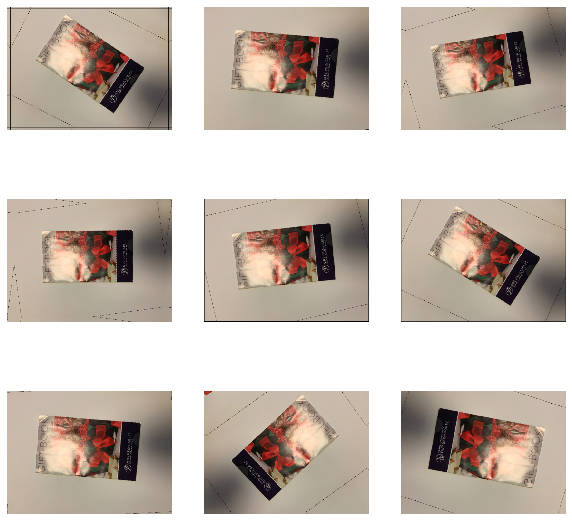

In [219]:
# Displaying transformed images.
plt.figure(figsize=(10, 10))
for images, _ in ds_train.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [197]:
# Defining model structure
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [198]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 384, 512, 3)       0         
_________________________________________________________________
rescaling_12 (Rescaling)     (None, 384, 512, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 384, 512, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 192, 256, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 192, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 96, 128, 32)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 96, 128, 64)      

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
epochs = 15
history = model.fit(
  ds_train,
  validation_data=ds_test,
  epochs=epochs
)

Epoch 1/15
64/64 [==============================] - 292s 5s/step - loss: 2.6355 - accuracy: 0.2423 - val_loss: 1.5626 - val_accuracy: 0.3604
Epoch 2/15
64/64 [==============================] - 302s 5s/step - loss: 1.4637 - accuracy: 0.4011 - val_loss: 1.5110 - val_accuracy: 0.4337
Epoch 3/15
64/64 [==============================] - 301s 5s/step - loss: 1.2808 - accuracy: 0.4975 - val_loss: 1.6930 - val_accuracy: 0.4158
Epoch 4/15
64/64 [==============================] - 291s 5s/step - loss: 1.1658 - accuracy: 0.5485 - val_loss: 1.2166 - val_accuracy: 0.5465
Epoch 5/15
64/64 [==============================] - 357s 6s/step - loss: 1.1196 - accuracy: 0.5737 - val_loss: 1.1604 - val_accuracy: 0.5703
Epoch 6/15
64/64 [==============================] - 518s 8s/step - loss: 1.0326 - accuracy: 0.6231 - val_loss: 1.0698 - val_accuracy: 0.5881
Epoch 7/15
64/64 [==============================] - 336s 5s/step - loss: 1.0294 - accuracy: 0.6147 - val_loss: 1.1259 - val_accuracy: 0.5743
Epoch 8/15
64

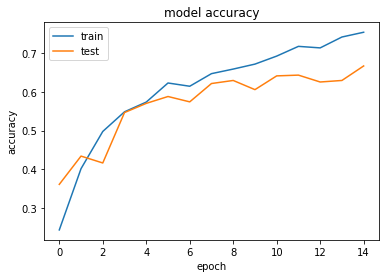

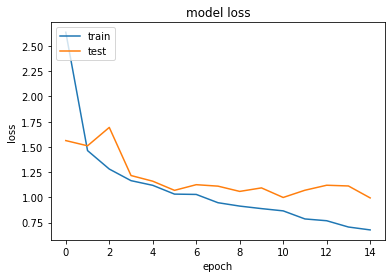

In [117]:
# Source for code below:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The plots above show a visual of the training performace metrics vs the testing performance metrics. These results are much better than the previous model with higher testing accuracy and less overfitting. Let's move forward with deploying this model to the django website. 

## Saving Model to Be Deployed to django Website

In [39]:
model.save('./model-75-67')

INFO:tensorflow:Assets written to: ./model-75-67/assets


## Checking Predictions on Validation Data

Now the fun part - let's see how OSCAR performed! We will load in an unseen image of a six pack of beer cans. This will be an interesting check to see how the model performs on an image that is unlike any of the training and testing data.

In [199]:
# Importing saved model
new_model = tf.keras.models.load_model('./models/model-75-67')

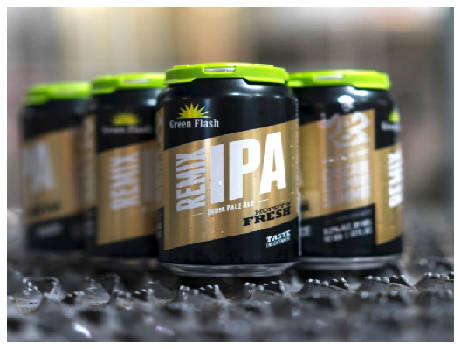

In [222]:
# Importing image
# Image borrowed from link below:
# https://www.thedrinksbusiness.com/2018/04/green-flash-brewing-sale-finalised-after-foreclosure/

new_img_path = './data/validation/beercan.png'
img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(img_height, img_width)
)
# Displaying transformed images.
plt.figure(figsize=(8, 25))
plt.imshow(img)
plt.axis("off");

In [200]:
# Processing image for predictions
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to metal with a 86.14 percent confidence.


Awesome!!! The model's prediction was correct in classifying the image as metal, and not too bad with an 86% confidence.

## Create ML Model

Because this model needs to be run on Create ML software, only images of its results are shown here. A brief description of what was done in the Create ML app is an image classification model type was chosen, and the testing data was automatically split from the training data by the program. I could not find the option to change this manually, so I was forced to stick with the default.

#### Accuracy

<img src="../images/creatml-acc.png" alt="image" width="850"/>

#### Training Evaluation

<img src="../images/createml-train.png" alt="image" width="650"/>

#### Testing Evaluation

<img src="../images/createml-test.png" alt="image" width="650"/>

I hate to admit it because the Create ML software is so autonomous, but this model ended up having the best results with the highest accuracy and the least overfitting. I am moving forward with this as the choice model. This is the model that was deployed to the iOS application in the `app` section of this repo.

# Findings + Conclusions

The model chosen to be OSCAR's deployable model was the CreateML model because it had the highest testing accuracy with minimal overfitting. The testing accuracy of 90% far exceeded the baseline accuracy of any category. See tables of results below:

|**Model**|**Train Accuracy**|**Test Accuracy**|
|---|---|---|
|Tensorflow|82.6%|78.5%|
|CreateML|92.8%|89.9%|

|**Class**|**Baseline Scores**|
|---|---|
|Cardboard|16%|
|Glass|20%|
|Metal|16%|
|Paper|23.5%|
|Plastic|19%|
|Trash|5.4%|

However, the CreateML model was not without its faults. Even though the testing accuracy was at 90%, the precision of the Trash class was exceptionally underperforming (see table below). I believe this is due to the imbalanced quantity of data for this category, combined with not enough data reserved for testing (I could not figure out how to change this option in CreateML, but will be added to my improvement to-dos).

|**Class**|**Precision**|
|---|---|
|Cardboard|100%|
|Glass|91%|
|Metal|93%|
|Paper|90%|
|Plastic|84%|
|Trash|25%|

At 138 pictures, the Trash category consisted of a maximum of 25% of the other categories. For instance, the Glass category had 500+ images. With this imbalance, the model could not learn the images of trash as well as the other classes and underperformed in the category as a result.

Even though this model performed well overall, it is apparent more images need to be collected for proper training. Hopefully with the crowd-sourcing effort of manually gathering data, OSCAR can one day be trained on 20,000+ images.

Aside from gathering more data, the next steps for this project include implementing educational tags within the iOS application to help the end user become more aware of what can and cannot be recycled, researching ways to improve the TensorFlow model, and working with the local municipality to determine what can and cannot go into the single-streamed recycling bins so it can be incorporated into the app's functionality.